In [1]:
import os
import pandas as pd
import shutil
from werkzeug.utils import secure_filename
from google.colab import files
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import Workbook
from openpyxl.styles import Alignment
from openpyxl.drawing.image import Image
from io import BytesIO

UPLOAD_FOLDER = 'uploads'

def merge_excel_files(input_folder, output_filename):
    merged_data = pd.DataFrame()
    excel_files = [f for f in os.listdir(input_folder) if f.startswith('Processed_') and f.endswith('.xlsx')]
    for file in excel_files:
        try:
            df = pd.read_excel(os.path.join(input_folder, file), engine='openpyxl')
            df = df[~((df['SLoc'] == 'FPS') & (df['Matl Group'] == 'MODULE') & (df[' Material'] != 2836601))]
            df = df[~((df['SLoc'] == 'FPS') & df['Material Description'].str.startswith('METAL BLOCK'))]
            df = df[~((df['SLoc'] == 'FPS') & df['Material Description'].str.startswith('CIRCUIT BLOCK'))]
            df = df[~((df['SLoc'] == 'MS') & (df['Matl Group'] == 'RMMODULE'))]
            df = df[~((df['SLoc'] == 'MS') & df['Material Description'].str.startswith('CROWN SPACER'))]
            merged_data = pd.concat([merged_data, df], ignore_index=True)
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")

    if not merged_data.empty:
        merged_data = merged_data.dropna(axis=1, how='all')
        merged_data['Total Quantity'] = (
            merged_data['      Unrestricted'] +
            merged_data['  In Quality Insp.'] +
            merged_data['           Blocked'] +
            merged_data['  Stock in Transit'] +
            merged_data['   Transit/Transf.']
        )
        merged_data['Total Value'] = (
            merged_data['Value Unrestricted'] +
            merged_data['Value in QualInsp.'] +
            merged_data['Value BlockedStock'] +
            merged_data['  Value in Transit'] +
            merged_data['Val. in Trans./Tfr']
        )
        total_quantity = merged_data['Total Quantity'].sum()
        total_value = merged_data['Total Value'].sum()
        totals_row = pd.DataFrame({'Total Quantity': [total_quantity], 'Total Value': [total_value]})
        merged_data.to_excel(output_filename, index=False)

def process_excel_file(input_filename, output_filename):
    df = pd.read_excel(input_filename)
    df = df.drop_duplicates(subset=df.columns.to_list(), keep='first')
    if df.iloc[0].isnull().all():
        df = df.iloc[1:]
    df = df.iloc[:, 1:]
    df = df.dropna(how='any')
    df = df[df.ne(df.columns).all(1)]
    df = df.dropna(how='all')
    df.to_excel(output_filename, header=False, index=False)

def remove_leading_spaces(x):
    return x.lstrip() if isinstance(x, str) else x

def add_classification_column(merged_filename, classification_filename):
    merged_data = pd.read_excel(merged_filename)
    merged_data[' Material'] = merged_data[' Material'].apply(remove_leading_spaces)
    classification_data = pd.read_excel(classification_filename)
    merged_data = merged_data.merge(classification_data, on=' Material', how='left')
    merged_data.to_excel(merged_filename, index=False)

def add_tag_columns1(merged_filename, tag1_filename):
    merged_data = pd.read_excel(merged_filename)
    tag1_data = pd.read_excel(tag1_filename)
    merged_data = merged_data.merge(tag1_data, on=' Material', how='left')
    merged_data.to_excel(merged_filename, index=False)

def add_tag_columns2(merged_filename, tag2_filename):
    merged_data = pd.read_excel(merged_filename)
    tag2_data = pd.read_excel(tag2_filename)
    merged_data['Tag'].fillna(merged_data['SLoc'].map(tag2_data.set_index('SLoc')['Tag']), inplace=True)
    merged_data.to_excel(merged_filename, index=False)

def create_pivot_table(merged_filename):
    merged_data = pd.read_excel(merged_filename)
    pivot_table = pd.pivot_table(merged_data, values='Total Value', index='Tag', columns='Classification', aggfunc='sum', fill_value=0)
    book = openpyxl.load_workbook(merged_filename)
    pivot_sheet = book.create_sheet(title='Pivot table')
    for r_idx, row in enumerate(dataframe_to_rows(pivot_table, index=True, header=True), 1):
        for c_idx, value in enumerate(row, 1):
            cell = pivot_sheet.cell(row=r_idx, column=c_idx, value=value)
            cell.alignment = Alignment(horizontal="center", vertical="center")
    book.save(merged_filename)

def upload_and_process():
  if os.path.exists(UPLOAD_FOLDER):
    shutil.rmtree(UPLOAD_FOLDER)
  while True:
    uploaded_files = files.upload()
    if not os.path.exists(UPLOAD_FOLDER):
        os.makedirs(UPLOAD_FOLDER)
    processed_files = []
    for filename, file_content in uploaded_files.items():
        temporary_file_path = os.path.join(UPLOAD_FOLDER, secure_filename(filename))
        with open(temporary_file_path, 'wb') as f:
            f.write(file_content)
        processed_filename = os.path.join(UPLOAD_FOLDER, f'Processed_{secure_filename(filename)}')
        process_excel_file(temporary_file_path, processed_filename)
        processed_files.append(processed_filename)
    if processed_files:
        print("Processed files:")
        for processed_file in processed_files:
            print(processed_file)
        merged_output_filename = os.path.join(UPLOAD_FOLDER, 'Merged_Files.xlsx')
        merge_excel_files(UPLOAD_FOLDER, merged_output_filename)
        print(f'Download the merged file: {merged_output_filename}')
        classification_upload = input("Upload Classification_Base.xlsx? (y/n): ").strip().lower()
        if classification_upload == 'y':
             classification_filename = next(iter(files.upload()))
             add_classification_column(merged_output_filename, classification_filename)
             print(f'Updated merged file with classification column: {merged_output_filename}')
        tag1_upload = input("Upload Tag1.xlsx? (y/n): ").strip().lower()
        if tag1_upload == 'y':
             tag1_filename = next(iter(files.upload()))
             add_tag_columns1(merged_output_filename, tag1_filename)
             print(f'Updated merged file with Tag1 column: {merged_output_filename}')
        tag2_upload = input("Upload Tag2.xlsx? (y/n): ").strip().lower()
        if tag2_upload == 'y':
             tag2_filename = next(iter(files.upload()))
             add_tag_columns2(merged_output_filename, tag2_filename)
             print(f'Updated merged file with Tag2 column: {merged_output_filename}')
        create_pivot_table(merged_output_filename)
    another_upload = input("Upload another file? (y/n): ").strip().lower()
    if another_upload != 'y':
      break

if __name__ == '__main__':
    upload_and_process()

Saving FPS.xlsx to FPS.xlsx
Saving MCFP.xlsx to MCFP.xlsx
Saving MPLC.xlsx to MPLC.xlsx
Saving MPRM.xlsx to MPRM.xlsx
Saving MS.xlsx to MS.xlsx
Saving TS-ALL.xlsx to TS-ALL.xlsx
Processed files:
uploads/Processed_FPS.xlsx
uploads/Processed_MCFP.xlsx
uploads/Processed_MPLC.xlsx
uploads/Processed_MPRM.xlsx
uploads/Processed_MS.xlsx
uploads/Processed_TS-ALL.xlsx
Download the merged file: uploads/Merged_Files.xlsx
Upload Classification_Base.xlsx? (y/n): y


Saving Classification_Base.xlsx to Classification_Base.xlsx
Updated merged file with classification column: uploads/Merged_Files.xlsx
Upload Tag1.xlsx? (y/n): y


Saving Tag_Base1.xlsx to Tag_Base1.xlsx
Updated merged file with Tag1 column: uploads/Merged_Files.xlsx
Upload Tag2.xlsx? (y/n): y


Saving Tag_Base2.xlsx to Tag_Base2.xlsx
Updated merged file with Tag2 column: uploads/Merged_Files.xlsx
Upload another file? (y/n): n


In [3]:
pip install pandas openpyxl XlsxWriter python-pptx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.8 MB/s eta 0:00:00


Chart saved to output_chart.pptx


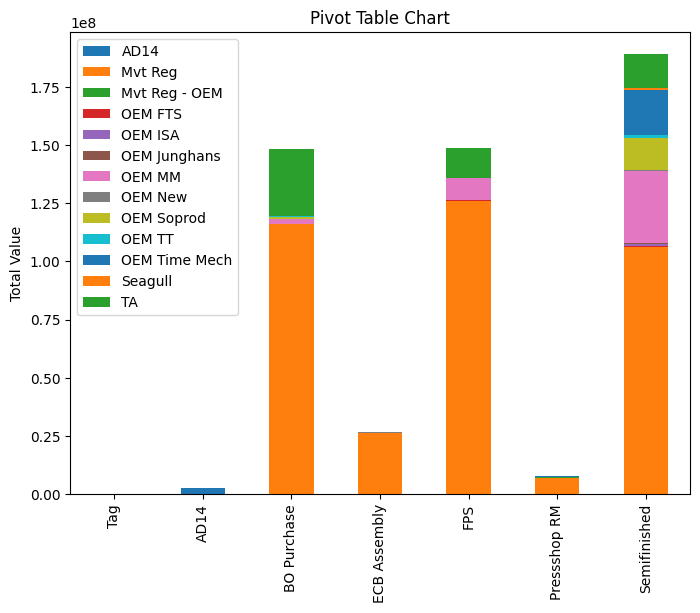

In [4]:
import openpyxl
import matplotlib.pyplot as plt
from io import BytesIO
from pptx import Presentation
from pptx.util import Inches

input_file = '/content/uploads/Merged_Files.xlsx'
workbook = openpyxl.load_workbook(input_file)
pivot_sheet = workbook['Pivot table']

pivot_data = list(pivot_sheet.iter_rows(values_only=True))
headers = pivot_data[0]
data = pivot_data[1:]

index_column = headers[0]
data_columns = headers[1:]

df = pd.DataFrame(data, columns=headers)
df.set_index(index_column, inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))
df.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel(index_column)
ax.set_ylabel('Total Value')
ax.set_title('Pivot Table Chart')

image_stream = BytesIO()
plt.savefig(image_stream, format='png')
image_stream.seek(0)

presentation = Presentation()

slide_layout = presentation.slide_layouts[5]
slide = presentation.slides.add_slide(slide_layout)

left = Inches(1)
top = Inches(1)
height = Inches(4.5)
picture = slide.shapes.add_picture(image_stream, left, top, height=height)

output_pptx = 'output_chart.pptx'
presentation.save(output_pptx)

print(f'Chart saved to {output_pptx}')

In [5]:
from pptx import Presentation

pptx_file = '/content/output_chart.pptx'
presentation = Presentation(pptx_file)

def extract_images_from_pptx(presentation, image_output_folder):
    for i, slide in enumerate(presentation.slides):
        for j, shape in enumerate(slide.shapes):
            if hasattr(shape, "image"):
                image = shape.image
                image_bytes = image.blob
                with open(f"{image_output_folder}/image_{i + 1}_{j + 1}.png", "wb") as f:
                    f.write(image_bytes)

image_output_folder = 'extracted_images'
if not os.path.exists(image_output_folder):
    os.makedirs(image_output_folder)

extract_images_from_pptx(presentation, image_output_folder)

print(f'Images extracted and saved to {image_output_folder}')


Images extracted and saved to extracted_images


In [7]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email import encoders

def send_email_with_attachment_and_image(sender_email, recipient_email, subject, body_text, pptx_file, image_file, smtp_server, smtp_port, smtp_username, smtp_password):
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = subject

    attachment = open(pptx_file, "rb")
    base = MIMEBase('application', 'octet-stream')
    base.set_payload((attachment).read())
    encoders.encode_base64(base)
    base.add_header('Content-Disposition', "attachment; filename= %s" % pptx_file)
    msg.attach(base)

    image = open(image_file, 'rb').read()
    msgText = MIMEText('<img src="cid:image1">', 'html')
    msg.attach(msgText)
    msgImage = MIMEImage(image, 'png')
    msgImage.add_header('Content-ID', '<image1>')
    msg.attach(msgImage)

    msg.attach(MIMEText(body_text, 'plain'))

    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()
        server.login(smtp_username, smtp_password)
        text = msg.as_string()
        server.sendmail(sender_email, recipient_email, text)
        server.quit()
        print("Email sent successfully.")
    except Exception as e:
        print(f"Error sending email: {str(e)}")

sender_email = 'sanjaibanumathi@gmail.com'
recipient_email = 'akeerthana1610@gmail.com'
subject = 'Email with Attachment and Image'
body_text = 'This email contains an attachment and an embedded image.'
smtp_server = 'smtp.gmail.com'
smtp_port = 587
smtp_username = 'example@gmail.com'
smtp_password = '12345678'

pptx_file = 'output_chart.pptx'
image_file = '/content/extracted_images/image_1_2.png'

send_email_with_attachment_and_image(
    sender_email, recipient_email, subject, body_text, pptx_file, image_file, smtp_server, smtp_port, smtp_username, smtp_password
)

Email sent successfully.
